In [7716]:
import numpy as np
import matplotlib.pyplot as plt

Assume Uniform Linear Array (ULA) w/ d = $\lambda/2$ and calculate steering vector for some narrrowband signal tx

In [7717]:
sample_rate = 1e6 
N = 10000 # number of observations
d= 0.5 # Half Wavelengh 
Nr = 6 # Number of sensors
t = np.arange(N)/sample_rate # time vector

f_tone = 0.02e6 #tone frequency
tx = 10*np.exp(2j * np.pi * f_tone * t)
theta_degrees = -37 # direction of arrival 
theta = theta_degrees / 180 * np.pi #convert to radians
s = np.exp(-2j * np.pi * d * np.arange (Nr) * np.sin(theta)) # Steering Vector

In [7718]:
s = s.reshape(-1,1) # make s a column vector
print(s.shape) # 3x1
tx = tx.reshape(1,-1) # make tx a row vector
print(tx.shape) # 1x10000

X = s @ tx # Simulate the received signal X through a matrix multiply
print(X.shape) # 3x10000.  X is now going to be a 2D array, 1D is time and 1D is the spatial dimension

(6, 1)
(1, 10000)
(6, 10000)


In [7719]:
n = np.random.randn(Nr, N) + 1j*np.random.randn(Nr, N)
print(np.shape(n))
X = X + 0.001*n # X and n are both 3x10000

(6, 10000)


The MVDR/Capon beamformer can be summarized in the following equation:

$w_{mvdr} = \frac{R^{-1} s}{s^H R^{-1} s}$
where R is spatial covariance matrix i.e $R = XX^H$, and $s$ is steering vector (desired)

In [7720]:
# theta is the direction of interest, in radians, and X is our received signal
def w_mvdr(s):
   s = s.reshape(-1,1) # make into a column vector (size Nrx1)
   R = (X @ X.conj().T)/X.shape[1] # Calc covariance matrix. gives a Nr x Nr covariance matrix of the samples
   Rinv = np.linalg.pinv(R) # 3x3. pseudo-inverse tends to work better/faster than a true inverse
   w = (Rinv @ s)/(s.conj().T @ Rinv @ s) # MVDR/Capon equation! numerator is Nrx3 * Nrx1, denominator is 1xNr * NrxMr * Nrx1, resulting in a 3x1 weights vector
   return w

Perform MVDR for given steering vector 

In [7721]:
s = np.ones(Nr)
w = w_mvdr(s)
w = w.reshape(1, -1)
print(w)

[[0.17071162+0.01937176j 0.15407332-0.00205644j 0.18094247-0.02013426j
  0.17962647+0.01950739j 0.14699406+0.00182815j 0.16765206-0.0185166j ]]


Plot polar coordinates

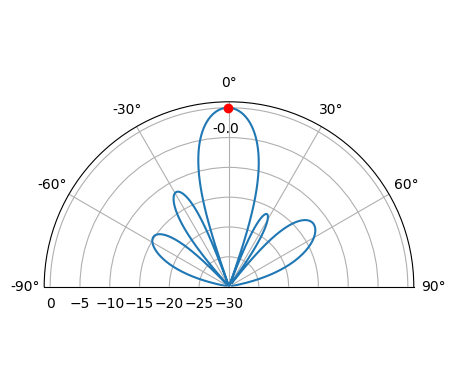

In [7722]:
N_fft = 1024

w_padded = np.concatenate((w[0], np.zeros(N_fft - Nr))) # zero pad to N_fft elements to get more resolution in the FFT
w_fft_dB = 10*np.log10(np.abs(np.fft.fftshift(np.fft.fft(w_padded)))**2) # magnitude of fft in dB
w_fft_dB -= np.max(w_fft_dB) # normalize to 0 dB at peak

# Map the FFT bins to angles in radians
theta_bins = np.arcsin(np.linspace(-1, 1, N_fft)) # in radians

# find max so we can add it to plot
theta_max = theta_bins[np.argmax(w_fft_dB)]

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(theta_bins, w_fft_dB) # MAKE SURE TO USE RADIAN FOR POLAR
ax.plot([theta_max], [np.max(w_fft_dB)],'ro')
ax.text(theta_max - 0.1, np.max(w_fft_dB) - 4, np.round(theta_max * 180 / np.pi))
ax.set_theta_zero_location('N') # make 0 degrees point up
ax.set_theta_direction(-1) # increase clockwise
ax.set_rlabel_position(55)  # Move grid labels away from other labels
ax.set_thetamin(-90) # only show top half
ax.set_thetamax(90)
ax.set_ylim([-30, 1]) # because there's no noise, only go down 30 dB

plt.show()


Plot rectangular coordinates

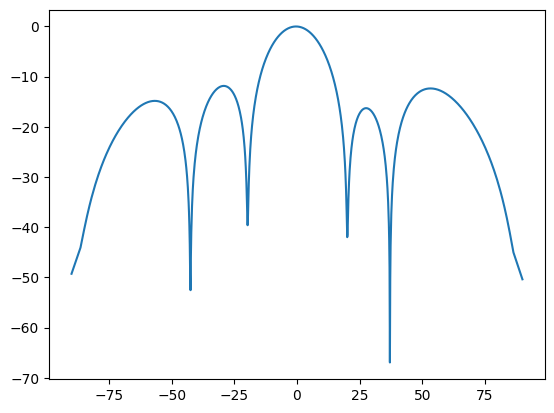

-37.09425809612872


In [7723]:
theta_scan = np.arcsin(np.linspace(-1, 1, N_fft))
plt.plot(theta_scan*180/np.pi, w_fft_dB)
plt.show()
print(-theta_scan[np.argsort(w_fft_dB)[0]]*180/np.pi)